## Задание по программированию: Бэггинг и случайный лес

Загрузите датасет digits с помощью функции load_digits из sklearn.datasets и подготовьте матрицу признаков X и ответы на обучающей выборке y (вам потребуются поля data и target в объекте, который возвращает load_digits).

Для оценки качества далее нужно будет использовать cross_val_score из sklearn.cross_validation с параметром cv=10. Эта функция реализует k-fold cross validation c k равным значению параметра cv. Мы предлагаем использовать k=10, чтобы полученные оценки качества имели небольшой разброс, и было проще проверить полученные ответы. На практике же часто хватает и k=5. Функция cross_val_score будет возвращать numpy.ndarray, в котором будет k чисел - качество в каждом из k экспериментов k-fold cross validation. Для получения среднего значения (которое и будет оценкой качества работы) вызовите метод .mean() у массива, который возвращает cross_val_score.

С небольшой вероятностью вы можете натолкнуться на случай, когда полученное вами качество в каком-то из пунктов не попадет в диапазон, заданный для правильных ответов - в этом случае попробуйте перезапустить ячейку с cross_val_score несколько раз и выбрать наиболее «типичное» значение. Если это не помогает, то где-то была допущена ошибка.

Если вам захочется ускорить вычисление cross_val_score - можете попробовать использовать параметр n_jobs, но будьте осторожны: в одной из старых версий sklearn была ошибка, которая приводила к неверному результату работы cross_val_score при задании n_jobs отличным от 1. Сейчас такой проблемы возникнуть не должно, но проверить, что все в порядке, не будет лишним.

In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from matplotlib import pyplot as plt

digits = load_digits()
X = digits.data
Y = digits.target

Данные состоят из 1797 объектов для каждого из которых заданы 64 признака и соответсвующие метки классов:

In [2]:
print(X.shape, Y.shape)

(1797, 64) (1797,)


Попробуем нарисовать чиселки из датасета

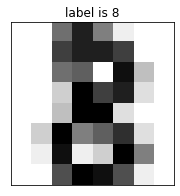

In [11]:
def plot_number_by_data(img_data, label):
    plt.figure(1, figsize=(3, 3))
    plt.imshow(img_data.reshape((8,8)), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.title(f"label is {label}")
    plt.show()

def plot_number_by_index(ind):
    dt = X[ind]
    label = Y[ind]
    plot_number_by_data(dt, label)

plot_number_by_index(8)

В задании нужно измерять качество работы классификаторов на кросс валидации c 10 фолдами, поэтому сразу напишем функцию для общего интерфейса и заодно функцию для рисования тех чисел, где классификатор ошибся.

In [4]:
#just evaluate mean 10-fold cross validation score.
def fit_estimator(estimator):
    return cross_val_score(estimator, X, Y, cv=10).mean()
       
#plot digits where classifier made mistake.   
def plot_invalid_labels(estimator):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=51)
    estimator.fit(X_train, y_train)
    predict = estimator.predict(X_test)
    
    fig=plt.figure(figsize=(15, 10))
    columns = 5
    rows = 4
    j = 1
    for i in np.arange(len(predict)):
        p = predict[i]
        a = y_test[i]
        if p != a:
            if j <= rows*columns:
                img = X_test[i].reshape((8,8))
                fig.add_subplot(rows, columns, j)
                plt.imshow(img)
                plt.xticks([])
                plt.yticks([])
                fig.tight_layout() 
                plt.title(f"label is {a} pr {p}")
                j+=1
    plt.show()   

Хорошо, теперь можно приступать к обучению. Сначала начинам с дерева решения.

1.

    Создайте DecisionTreeClassifier с настройками по умолчанию и измерьте качество его работы с помощью cross_val_score. Эта величина и будет ответом в пункте 1.

Так и сделаем, только зафиксируем random_state чтобы результаты были воспроизводимы и заодно посмотрим на каких числах классификатор ошибался.

Accuracy:  0.8263625077591558


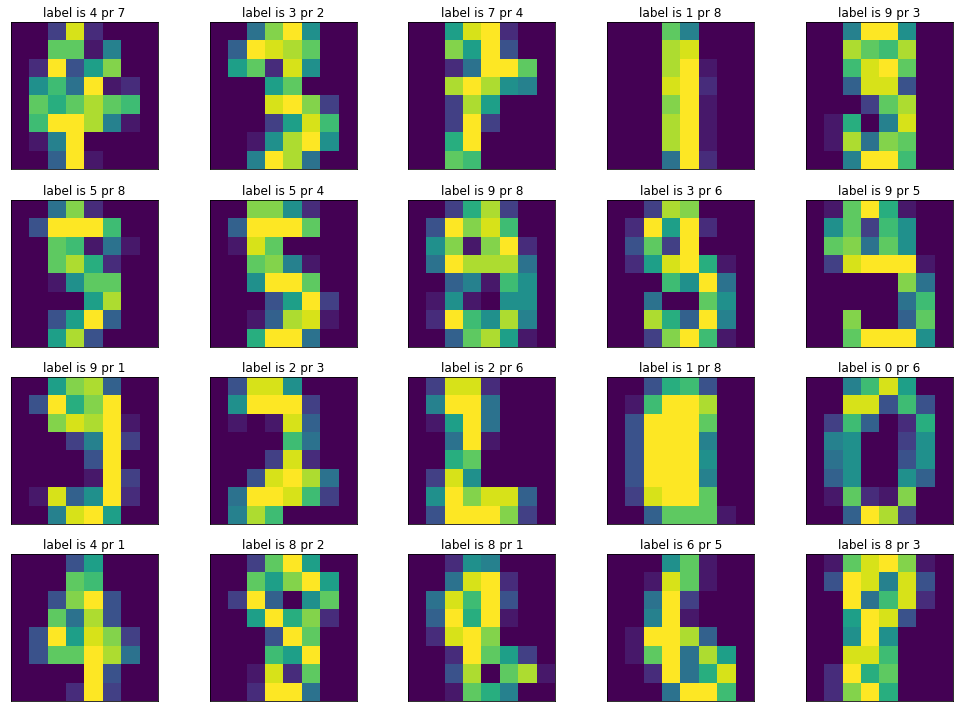

In [5]:
#leave estimator as is with default params
d_tree1 = DecisionTreeClassifier(random_state=17)
print("Accuracy: ",fit_estimator(d_tree1))

plot_invalid_labels(d_tree1)

Получили примерно 82 процента точности что в принципе неплохо и по некоторым картинкам не совсем понятно какое число изображено. Идем дальше.

2.

    Воспользуйтесь BaggingClassifier из sklearn.ensemble, чтобы обучить бэггинг над DecisionTreeClassifier. Используйте в BaggingClassifier параметры по умолчанию, задав только количество деревьев равным 100.

У нас уже есть решающее дерево и нам нужно обучить беггинг над ним. Вспомним, что беггинг это среднее значение всех алгоритмов на бутстрепе подвыборок. Значит нам нужно создать класс BaggingClassifier и передать ему в параметры дерево решений. Так и сделаем

In [6]:
d_tree = DecisionTreeClassifier(random_state=37)
bagging = BaggingClassifier(base_estimator=d_tree, random_state=11, n_estimators=100)
fit_estimator(bagging)

0.9237181874612045

Видим, что качество сильно возросло. Но как мы помним, такая композиция все же немного коррелирована, так как все деревья обучаются на одних и тех же признаках. И тут есть два варианта.

3.

    Теперь изучите параметры BaggingClassifier и выберите их такими, чтобы каждый базовый алгоритм обучался не на всех d признаках, а на $\sqrt{d} $ случайных признаков. Качество работы получившегося классификатора - ответ в пункте 3. Корень из числа признаков - часто используемая эвристика в задачах классификации, в задачах регрессии же часто берут число признаков, деленное на три. Но в общем случае ничто не мешает вам выбирать любое другое число случайных признаков.

Сейчас нужно выбрать $\sqrt{d} $ для построения всего дерева за что отвечает параметр max_features

In [7]:
d_tree = DecisionTreeClassifier(random_state=37)

bagging = BaggingClassifier(base_estimator=d_tree, random_state=11, n_estimators=100, max_features=int(np.sqrt(X.shape[1])))

fit_estimator(bagging)

0.9293358162631906

Качество чуть выросло, но тут мы использовали рандомную выборку из  признаков для построения всего дерева. Теперь нужно будет использовать рандомные  признаков для построения каждого ветвления.

4.

Наконец, давайте попробуем выбирать случайные признаки не один раз на все дерево, а при построении каждой вершины дерева. Сделать это несложно: нужно убрать выбор случайного подмножества признаков в BaggingClassifier и добавить его в DecisionTreeClassifier. Какой параметр за это отвечает, можно понять из документации sklearn, либо просто попробовать угадать (скорее всего, у вас сразу получится). Попробуйте выбирать опять же $\sqrt{d}\$
  признаков. Качество полученного классификатора на контрольной выборке и будет ответом в пункте 4

In [8]:
d_tree = DecisionTreeClassifier(random_state=37, max_features=int(np.sqrt(X.shape[1])))

bagging = BaggingClassifier(base_estimator=d_tree, random_state=11, n_estimators=100)

fit_estimator(bagging)

0.94768156424581

Пока что получили самую большую точность - 95% процентов по кросс валидации. Последний построенный классификатор напоминает случайный лес, так как мы делаем беггинг и случайный отбор признаков и поэтому мы можем сравнить наш классификатор со случайным лесом, что и предлагается в следующем задании.

5.

    Полученный в пункте 4 классификатор - бэггинг на рандомизированных деревьях (в которых при построении каждой вершины выбирается случайное подмножество признаков и разбиение ищется только по ним). Это в точности соответствует алгоритму Random Forest, поэтому почему бы не сравнить качество работы классификатора с RandomForestClassifier из sklearn.ensemble. Сделайте это, а затем изучите, как качество классификации на данном датасете зависит от количества деревьев, количества признаков, выбираемых при построении каждой вершины дерева, а также ограничений на глубину дерева. Для наглядности лучше построить графики зависимости качества от значений параметров, но для сдачи задания это делать не обязательно.

Давайте сначала оценим работу RF от количества деревьев.

1
11
21
31
41
51
61
71
81
91
101
111
121
131
141


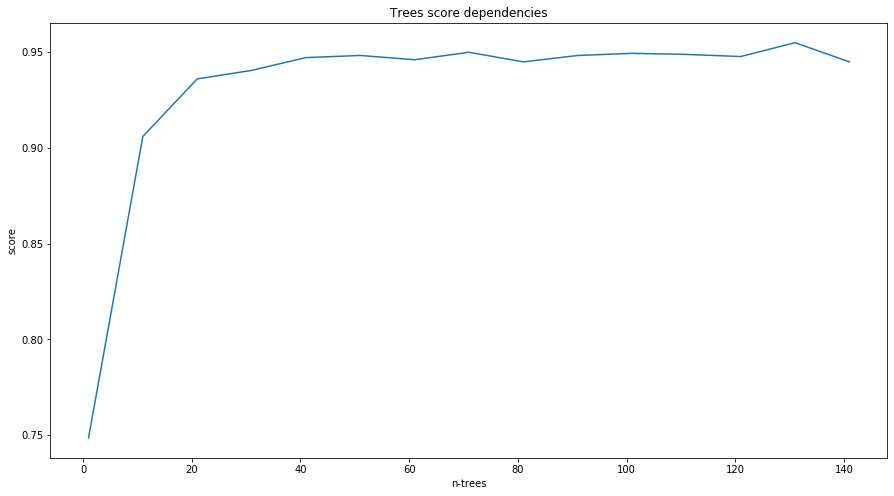

Wall time: 30 s


In [16]:
%%time
def plot_rf_trees_score():
    trees = np.arange(1,150,10)
    results = []
    for tree in trees:
        print(tree)
        rf = RandomForestClassifier(n_estimators=tree)
        results.append(fit_estimator(rf))
    plt.figure(figsize=(15, 8))
    plt.plot(trees, results)
    plt.xlabel("n-trees")
    plt.ylabel("score")
    plt.title("Trees score dependencies")
    plt.show()
plot_rf_trees_score()

Интересные получились результаты. Во первых, так как мы не ограничивали деревья в глубину, то алгоритм долго работал на тестовом датасете. Во вторых, средняя точность при разном кол-ве деревьев такая же, как и в случае беггинга на рандомных признаках, что и показывает применение всей вышеизложенной теории. А что касается зависимости точности от кол-ва деревьев, то судя по графику можно смело сказать, что алгоритм выходит на константу и дальнейшее увеличение деревьев не влияет на результат (вообще у меня сильно зависит от random_state). Посмотрим теперь как зависит качество от кол-ва рандомных признаков.

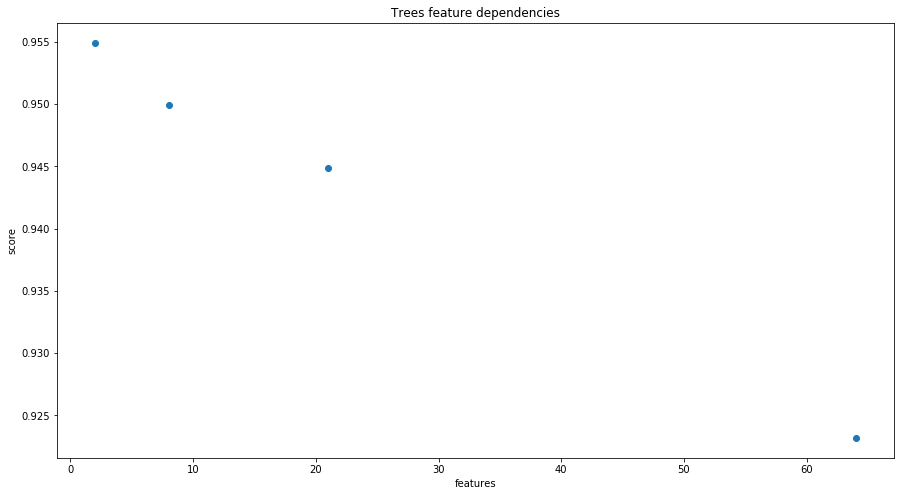

Wall time: 1min 21s


In [13]:
%%time
def plot_rf_trees_max_features():
    d = X.shape[1]
    features = [2, int(np.sqrt(d)), int(d/3), d]
    results = []
    for f in features:
        rf = RandomForestClassifier(n_estimators=400, random_state=101, max_features=f)
        results.append(fit_estimator(rf))
    plt.figure(figsize=(15, 8))
    plt.plot(features, results, 'o')
    plt.xlabel("features")
    plt.ylabel("score")
    plt.title("Trees feature dependencies")
    plt.show()
plot_rf_trees_max_features() 

Интересно, что предположение о том, что нужно брать где то sqrtd рандомных признаков неплохо подтверждается. У класса RandomForestClassifier параметр max_features по умолчанию стоит auto, и алгоритм сам решает, какой ему выбрать. Теперь посмотрим глубину дерева.

2
4
6
8


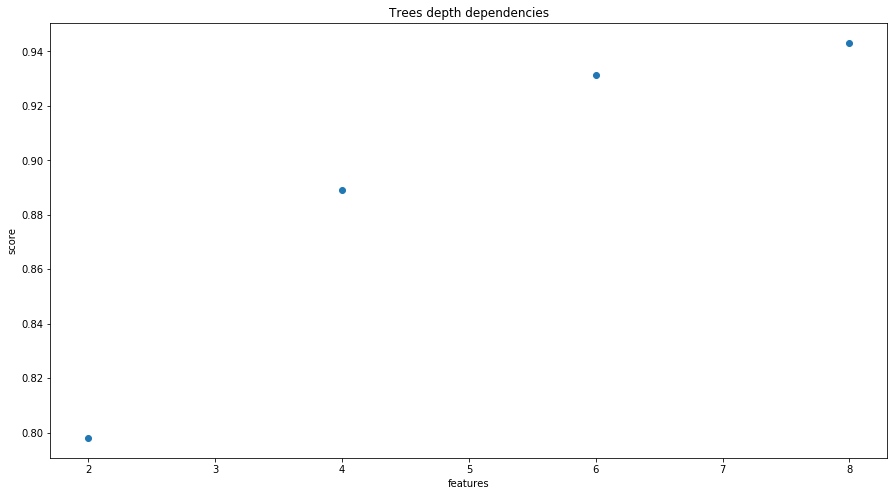

Wall time: 34.4 s


In [14]:
%%time
def plot_rf_tree_depth():
    d = X.shape[1]
    depth = [2, 4, 6, 8]
    results = []
    for d in depth:
        print(d)
        rf = RandomForestClassifier(n_estimators=400, random_state=101, max_depth=d)
        results.append(fit_estimator(rf))
    plt.figure(figsize=(15, 8))
    plt.plot(depth, results, 'o')
    plt.xlabel("features")
    plt.ylabel("score")
    plt.title("Trees depth dependencies")
    plt.show()
plot_rf_tree_depth()

Из графика видно, что чем больше глубина, тем больше точность предсказания. Но у нас время обучения значительно упало.

Итак, теперь можно ответить на вопросы в задании:

    1) Случайный лес сильно переобучается с ростом количества деревьев

Нет, это не так. Каждое дерево в случайном лесе сильно переобучается, а качество обучения композиции деревьев выходит на некую константу в зависимости от числа деревьев в композиции.

    2) При очень маленьком числе деревьев (5, 10, 15), случайный лес работает хуже, чем при большем числе деревьев


Да, это так. При композиции алгоритмов разброс ошибки обратно пропорционален кол-ву алгоритмов, поэтому при маленьком числе деревьев качество хуже, чем при большом. Это и показано на графике выше.

    3) С ростом количества деревьев в случайном лесе, в какой-то момент деревьев становится достаточно для высокого качества классификации, а затем качество существенно не меняется.

Да, это в точности отражено на графике.

    4) При большом количестве признаков (для данного датасета - 40, 50) качество классификации становится хуже, чем при малом количестве признаков (5, 10). Это связано с тем, что чем меньше признаков выбирается в каждом узле, тем более различными получаются деревья (ведь деревья сильно неустойчивы к изменениям в обучающей выборке), и тем лучше работает их композиция.



Все абсолютно верно. Чем меньше признаков, тем менее коррелированы становятся деревья. Но надо понимать, что слишком малое кол-во признаков не позволит “поймать” зависимость в данных.

    5) При большом количестве признаков (40, 50, 60) качество классификации лучше, чем при малом количестве признаков (5, 10). Это связано с тем, что чем больше признаков - тем больше информации об объектах, а значит алгоритм может делать прогнозы более точно.

Нет, это не верно. Почему это неверно, написано выше.

    6) При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса намного лучше, чем без ограничения глубины, т.к. деревья получаются не переобученными. С ростом глубины деревьев качество ухудшается.

Нет, это не так. Чем более переобучено дерево тем лучше это для композиции. Переобучение нам здесь на руку.

    7) При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса заметно хуже, чем без ограничений, т.к. деревья получаются недообученными. С ростом глубины качество сначала улучшается, а затем не меняется существенно, т.к. из-за усреднения прогнозов и различий деревьев их переобученность в бэггинге не сказывается на итоговом качестве (все деревья преобучены по-разному, и при усреднении они компенсируют переобученность друг-друга).


Да, это так, что и подтверждают графики выше.

Таким образом решающие деревья и их композиции очень крутой и простой инструмент машинного обучения. Случайный лес работает из коробки и позволяет достичь очень большой точности даже на стандартных параметрах.

In [ ]:
https://share.cocalc.com/share/6835f7803e0cbdcfd66c5b002390205179ab2f24/Seminar9/%D0%A1%D0%B5%D0%BC%D0%B8%D0%BD%D0%B0%D1%80%2028.02.html?viewer=download
  
https://artemarakcheev.com/2018-02-03/decision_trees_practics